Start from design and AF2 models of DHR39, DHR62, and DHR82 selected by AF2, nstruct 100

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [5]:
import os, stat

ala_pen = 2
met_pen = 1
np_pen = 3

nstruct = 100
def create_tasks(selected):
    with open(selected, "r") as f:
        for i, line in enumerate(f):
            tasks = {"-s": line.rstrip()}
            tasks["-ala_pen"] = ala_pen
            tasks["-met_pen"] = met_pen
            tasks["-np_pen"] = np_pen
            yield tasks

selected_af2 = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_af2_sample_firstmodel.list"
selected_des = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design_sample.list"

msd_py = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/msd.py"

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

slurm_dir = os.path.join(os.getcwd(), '05_two_state/slurm_logs')

tasklist = "05_two_state/run_2/05_msd_tasks.cmds"
run_sh = """#!/usr/bin/env bash \n#SBATCH -J 05_two_state \n#SBATCH -e {slurm_dir}/05_two_state-%J.err \n#SBATCH -o {slurm_dir}/05_two_state-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=8G \n
source activate /projects/crispy_shifty/envs/crispy\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
    slurm_dir=slurm_dir, queue='short', jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
)
shell = "05_two_state/run_2/05_msd.sh"
with open(shell, "w+") as f:
    print(run_sh, file=f)
st = os.stat(shell)
os.chmod(shell, st.st_mode | stat.S_IEXEC)
with open(tasklist, "w+") as f:
    for _ in range(nstruct):
        for tasks in create_tasks(selected_af2):
            tasks["-subfolder"] = 'af2_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)
        for tasks in create_tasks(selected_des):
            tasks["-subfolder"] = 'design_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
print(f"sbatch -a 1-$(cat {tasklist} | wc -l) {shell}")

Run the following commands
sbatch -a 1-$(cat 05_two_state/run_2/05_msd_tasks.cmds | wc -l) 05_two_state/run_2/05_msd.sh


In [12]:
# %%time

# retrieve the JSONs containing scores

import json

for model_type in ['af2', 'design']:

    output_paths = glob(f"05_two_state/run_2/{model_type}_decoys/*.json")

    scores = {}
    errors = []

    for test in tqdm(output_paths):
        key = test.replace("json", "pdb")
        try:
            with open(test, "r") as f:
                values = json.load(f)
            scores[key] = values
        except json.JSONDecodeError:
            errors.append(test)

    print(len(errors))

    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.T
    output_path = "05_two_state/run_2"
    output_file = os.path.join(output_path, f"{model_type}_scores.json")
    scores_df.to_json(output_file)

100%|██████████| 1200/1200 [00:01<00:00, 791.28it/s]


0


100%|██████████| 1198/1198 [00:01<00:00, 804.89it/s]


0


In [2]:
def histplot_df(df, hue_col=None, hue_order=None):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for ax, col in zip(axs.flatten(),cols):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
            hue=hue_col,
            hue_order=hue_order,
        )

    plt.tight_layout()

In [4]:
def print_scores(df):
    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        "parent",
    ]
    print_df = df[cols]

    from IPython.display import display
    with pd.option_context(
        # 'display.max_rows', 5,
        'display.max_columns', None,
        # 'display.width', 1000,
        # 'display.precision', 3,
        # 'display.colheader_justify', 'left'
    ):
        display(print_df)

In [5]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [6]:
def copy_designs(df, out_dir):
    import os
    import shutil
    # Copy designs to a folder
    os.makedirs(out_dir, exist_ok=True)
    
    keys = ['parent',
            'Y-X',
            'sap_A_X',
            'sap_B_X',
            'sap_Y',
            'sc_int_Y',
            'vbuns_Y',
            'wnm_hlx_X',
            'wnm_hlx_Y',
            'wnm_all_A_X',
            'wnm_all_B_X',
            'wnm_all_A_Y',
            'wnm_all_B_Y',
           ]

    for index, row in df.iterrows():
        filename = out_dir
        for key in keys:
            val = row[key]
            if type(val) != str:
                val = f'_{val:.03f}'
            filename += val
        filename += '.pdb'
    #     print(filename)
        shutil.copy(index[:-4], filename)

In [7]:
def get_parents(df):
    parents = []
    for key, row in df.iterrows():
        parent = row['parent']
        if parent not in parents:
            parents.append(parent)
    print(len(parents))
    return parents

#### Analyze and filter MSD starting from AF2 models ####

In [13]:
output_path = "05_two_state/run_2"
output_file = os.path.join(output_path, "af2_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y
05_two_state/run_2/af2_decoys/8ba6779f39e900d7c38b33cdcb8be61d2416185606595e39.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.0,713.315308,1137.689575,...,-1323.911621,-1302.075562,1,6,0.280639,1.358968,0.261648,5.000000,0.101865,0.145690
05_two_state/run_2/af2_decoys/17b5f018f103054bf70b69383803a9a6c4cb8d5639f6f669.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,469.840790,695.218018,...,-948.819946,-944.420715,0,2,0.280550,0.493832,0.181797,0.402981,0.113158,0.206446
05_two_state/run_2/af2_decoys/d4edb8d485a7e3c5fe818d12b57da4e8a3c4deeaca1a12e9.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.0,661.585510,1067.979858,...,-1329.483643,-1336.601807,2,9,0.331650,0.718788,0.281923,0.784828,0.176198,0.156556
05_two_state/run_2/af2_decoys/1d0a5e05a4320761e720f4638ebf93b935b0c0220988cbb5.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.0,623.278503,1033.097168,...,-1335.578857,-1226.142090,1,4,0.264819,0.652733,0.303873,0.569386,0.107903,0.135719
05_two_state/run_2/af2_decoys/5f12bf825f588ad3efc8a26efcb87d339597b59c82791ea4.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.0,661.585510,1067.979858,...,-1314.890259,-1316.807251,0,6,0.268688,0.449599,0.287930,0.758726,0.168421,0.121608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_2/af2_decoys/335a6fefff6d25e88ba3586bd8ecee5e0947ec828093a05a.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,423.091095,629.029480,...,-961.473267,-920.321716,0,1,0.188629,0.609935,0.212379,0.807515,0.116810,0.268790
05_two_state/run_2/af2_decoys/8745d8abfe220d2519018370c9e21b11b5e8455212bf79ea.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.0,639.776733,1027.007690,...,-1325.704712,-1328.886230,0,2,0.284552,0.594866,0.254677,5.000000,0.141381,0.142966
05_two_state/run_2/af2_decoys/c4210836ce9beccf1c893fc5d512f134d3ac15dbf6ddbe01.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.0,688.716064,1160.174194,...,-1287.287231,-1322.129272,0,9,0.303953,0.478186,0.278013,0.522138,0.145534,0.155092
05_two_state/run_2/af2_decoys/8509362f1180fb5a117b7858a346a12de1aa25d73a5d9ba5.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.0,623.278503,1033.097168,...,-1313.814331,-1195.669922,0,3,0.306351,0.757483,0.308955,0.647875,0.110371,0.143667


In [14]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

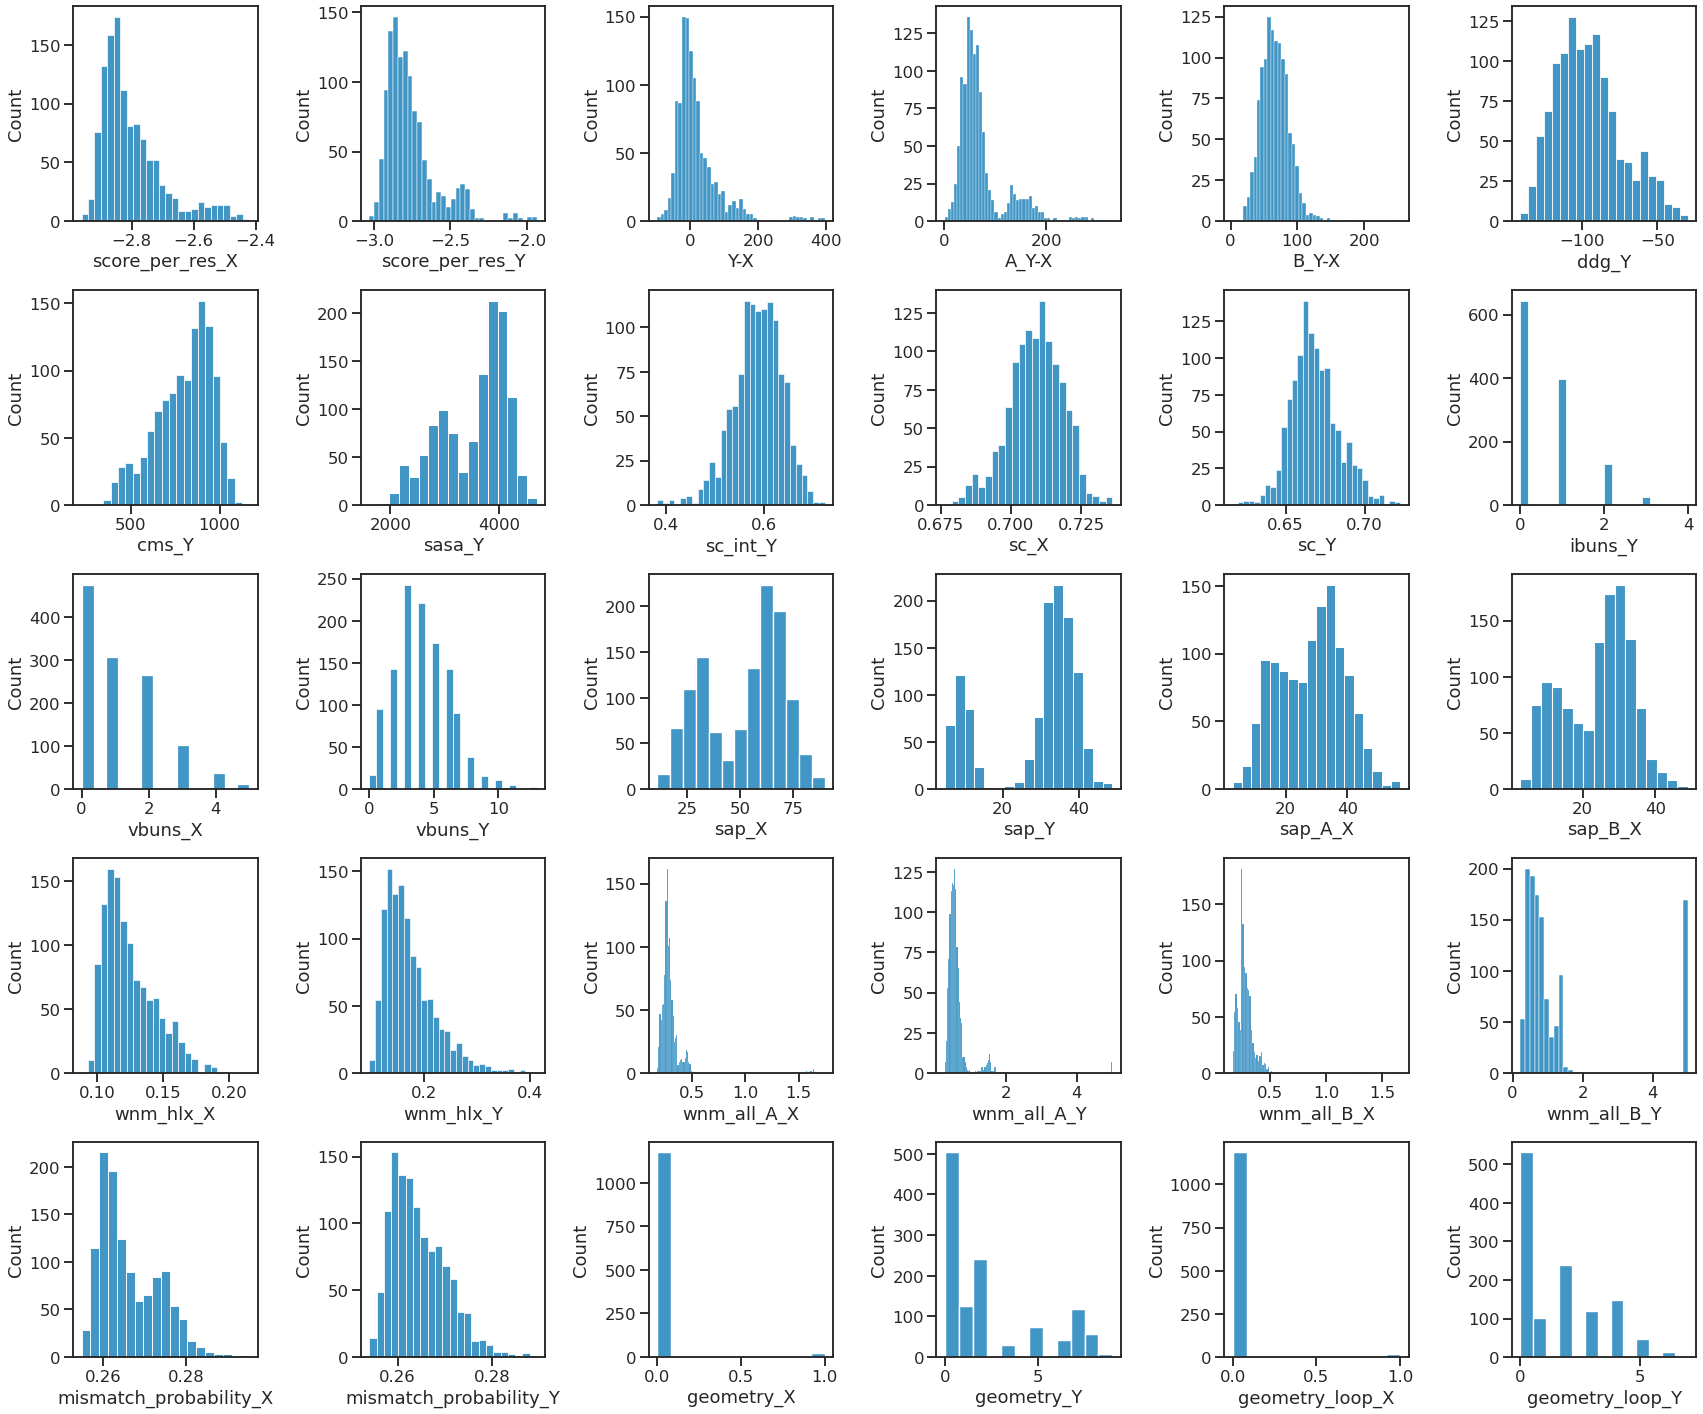

In [16]:
histplot_df(scores_df)

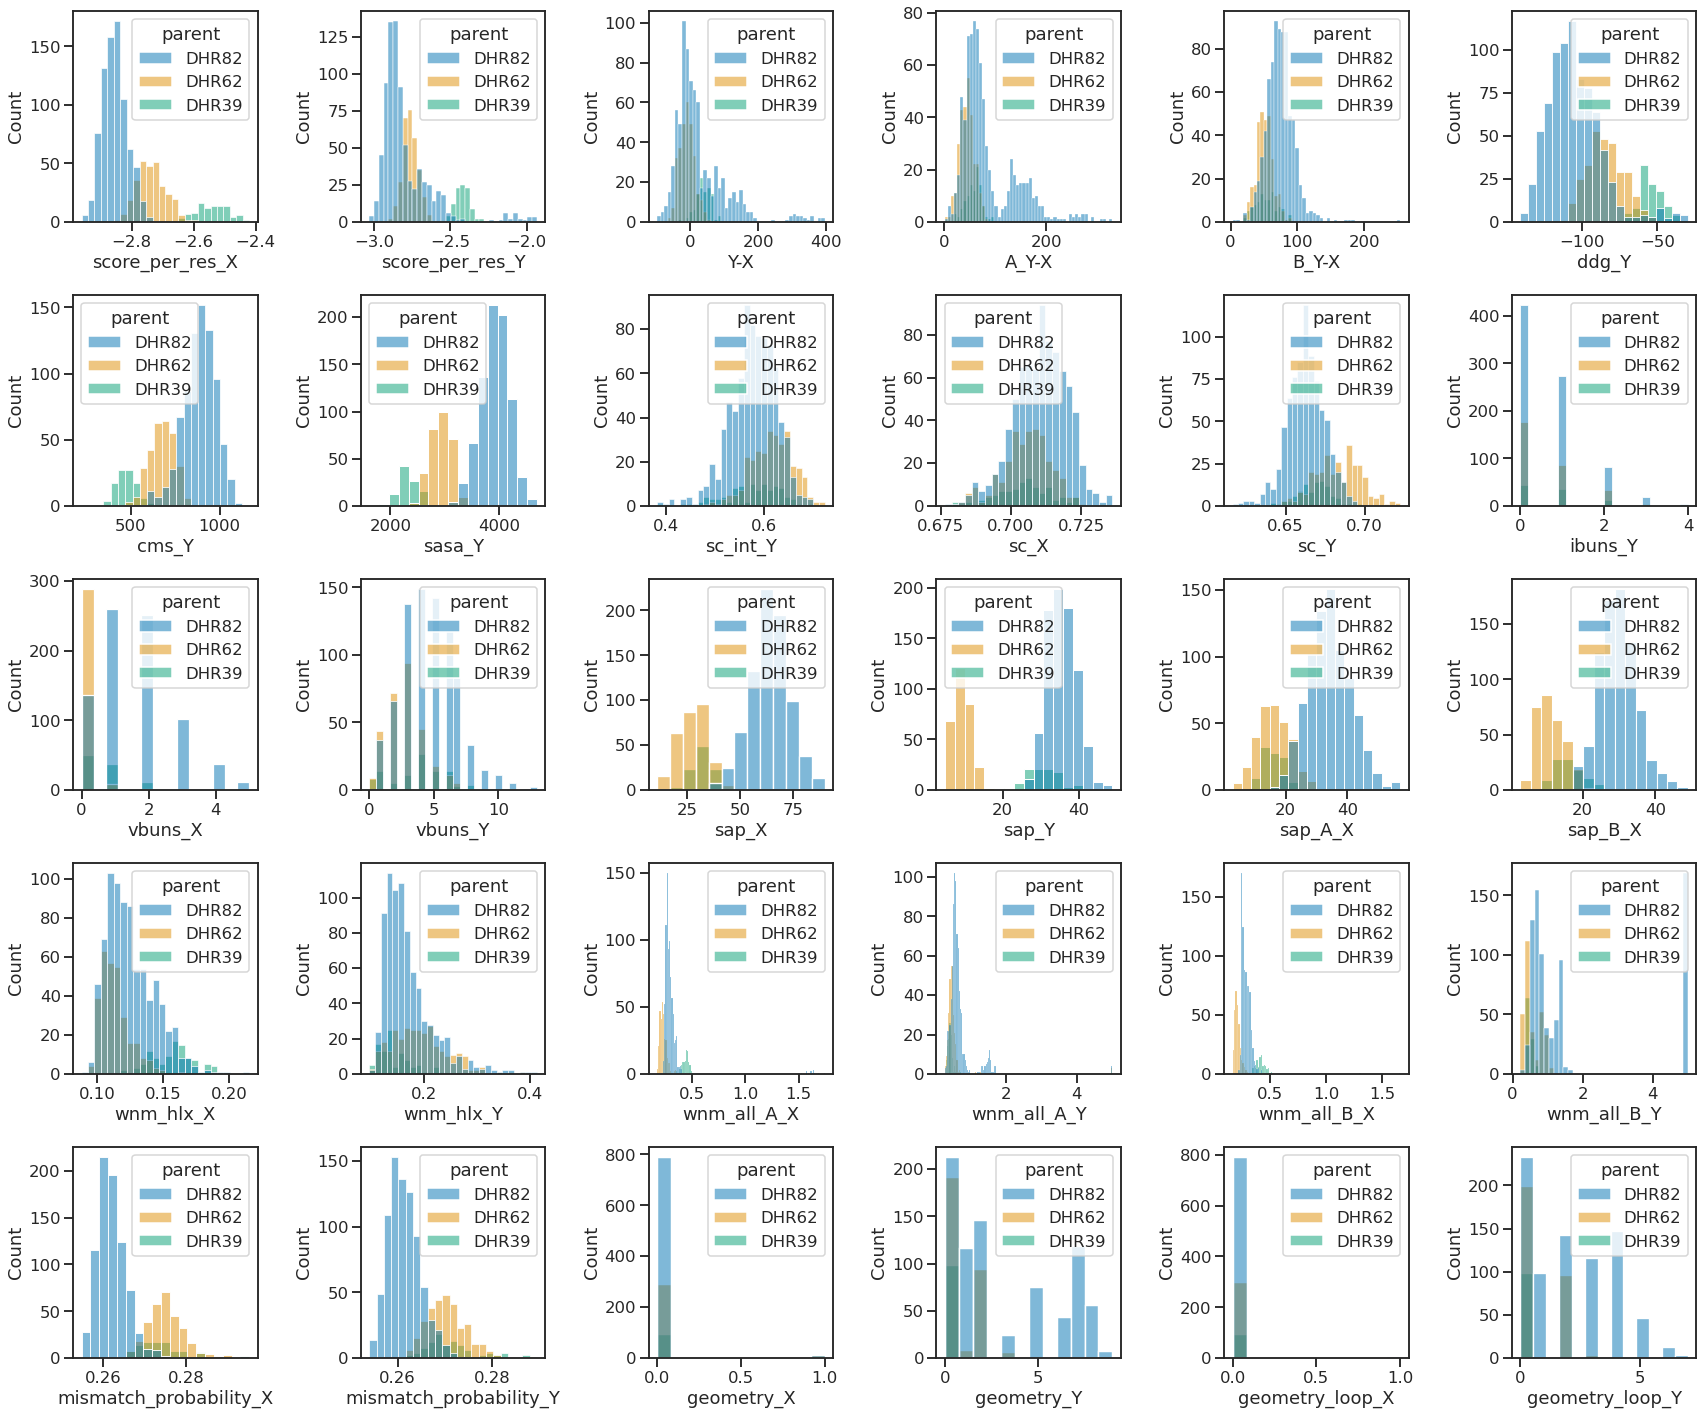

In [17]:
histplot_df(scores_df, 'parent')

In [18]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

11


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_2/af2_decoys/2ed2d160048f4d6bf5ca3d2fcf9c4f9e6c2caef06fe58007.pdb,-2.762987,-2.879126,-39.951721,54.208282,44.721619,-104.444984,843.699158,3308.709473,0.677472,0.708431,0.687800,1,0,1,42.317020,9.602109,15.640194,26.676809,0.119419,0.129478,0.222669,0.589625,0.208375,0.479689,0.272415,0.266998,0,0,0,0,DHR62
05_two_state/run_2/af2_decoys/2be5d606689d5d12d21f9af3b3f1de6a5bc9b4f80f2042f0.pdb,-2.657790,-2.720068,-21.423462,61.269287,32.529877,-88.239799,753.452698,3096.256592,0.682487,0.707079,0.708577,1,0,1,29.785711,8.673957,21.921497,7.864226,0.102866,0.167880,0.198452,0.432454,0.217087,0.931167,0.274975,0.270641,0,2,0,2,DHR62
05_two_state/run_2/af2_decoys/c53763fe86b4f3610aaca9e057bfb904479b2bf612b4cfaf.pdb,-2.661144,-2.793428,-45.505798,37.340363,40.447479,-90.623688,766.919800,3005.134766,0.676944,0.702563,0.697788,0,0,1,34.728031,8.191461,16.935383,17.792650,0.113406,0.124851,0.223049,0.468937,0.243350,0.349595,0.278096,0.277748,1,0,0,0,DHR62
05_two_state/run_2/af2_decoys/61105344243d6dcda392aa46b7473ccc60d37ed43c6c169d.pdb,-2.733752,-2.773348,-13.621155,42.504913,43.346069,-76.057800,657.681213,2813.128662,0.656890,0.708182,0.666760,1,0,1,18.791016,6.604943,10.946516,7.844506,0.110017,0.175868,0.208425,0.488273,0.216024,0.424681,0.271398,0.270524,0,0,0,0,DHR62
05_two_state/run_2/af2_decoys/13d7adeca435cd49d87979bd0ea621afa37b31de6334b063.pdb,-2.752158,-2.798869,-16.068481,36.942322,62.565460,-102.177917,707.718262,2888.438721,0.668636,0.706306,0.704982,0,0,2,31.836540,7.714709,22.674805,9.161717,0.109328,0.177359,0.226570,0.557536,0.210794,0.919189,0.276981,0.267658,0,2,0,2,DHR62
05_two_state/run_2/af2_decoys/1fbec1f7d80759aa455e9c2f0284edc94615acf0305b656d.pdb,-2.759007,-2.805025,-15.830383,37.655975,55.272888,-92.087952,670.918518,2862.342773,0.650808,0.715790,0.696065,0,0,2,29.767254,7.011641,22.622198,7.145059,0.109474,0.179444,0.187246,0.508070,0.210559,0.825359,0.272493,0.262509,0,2,0,2,DHR62
05_two_state/run_2/af2_decoys/d94e852cae5ed8ddbddb769f269921d49447472d5c7ea5cc.pdb,-2.693234,-2.774366,-27.909363,16.286163,63.964172,-86.425156,673.551575,2778.234863,0.662811,0.685518,0.703074,0,0,2,36.290237,8.897686,20.589493,15.700747,0.111560,0.187757,0.245544,0.501404,0.173094,0.924031,0.277034,0.269632,0,2,0,2,DHR62
05_two_state/run_2/af2_decoys/8e7013a03586654c536bc25bae6a2dfad1c99ef37b36f610.pdb,-2.717019,-2.798580,-28.056885,44.761444,49.270477,-104.464363,774.959839,3139.530029,0.690177,0.691703,0.709222,0,0,2,32.485115,9.398634,16.199043,16.286068,0.102118,0.183600,0.193629,0.425712,0.219637,0.637643,0.277434,0.272246,1,2,0,2,DHR62
05_two_state/run_2/af2_decoys/53bb5202493f058b71c8b782135b44f3511d73d861b2e7ba.pdb,-2.767152,-2.806928,-13.683105,47.019592,65.455444,-105.820580,829.105164,3239.339111,0.698500,0.718690,0.691265,0,0,2,32.912247,7.463826,19.864399,13.047835,0.102642,0.119990,0.206220,0.414229,0.206886,0.384422,0.275955,0.271571,0,0,0,0,DHR62
05_two_state/run_2/af2_decoys/8c7ae374864dc32ed1cc9a9b036f11f75befbab0d4b0e850.pdb,-2.657716,-2.773907,-39.969604,32.112396,56.614105,-107.940338,752.136658,3014.297363,0.683458,0.695526,0.692597,0,0,1,35.513157,7.720641,21.530586,13.982579,0.115262,0.186274,0.241737,0.615364,0.201365,0.413960,0.280091,0.270481,0,0,0,0,DHR62


In [19]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.6, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 5, 0),
]

global_df_2 = filter_df(scores_df, cutoffs)
print_scores(global_df_2[global_df_2['parent']=='DHR82'])

# increasing the vbuns_Y cutoff to 5 will get you some DHR82 designs... hmm...
# seems there is a tradeoff between vbuns_Y and sc_int_Y

67


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_2/af2_decoys/3c7c04a9a210cbc2eedfcd385c85bde97ed0a031f12d0ed5.pdb,-2.836413,-2.884742,-22.425049,46.865112,63.854065,-104.893600,930.184875,3916.982666,0.613281,0.69835,0.659801,0,1,4,60.964993,37.263863,30.849216,30.115801,0.123230,0.181410,0.242990,0.500477,0.351780,0.561940,0.267697,0.266068,0,0,0,0,DHR82
05_two_state/run_2/af2_decoys/95c728c0c3d37472550b635359a2ef1b0eb8d7579171c884.pdb,-2.784975,-2.850593,-30.446777,63.016357,47.892212,-111.937515,860.053955,3792.171875,0.605717,0.71519,0.649097,0,1,4,59.648712,38.002228,32.736195,26.912493,0.109233,0.184886,0.321664,0.477654,0.268761,0.543654,0.258740,0.257990,0,1,0,0,DHR82


In [20]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.57, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df_3 = filter_df(scores_df, cutoffs)
print_scores(global_df_3[global_df_3['parent']=='DHR82'])

# increasing the vbuns_Y cutoff to 5 will get you some DHR82 designs... hmm...
# seems there is a tradeoff between vbuns_Y and sc_int_Y

36


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_2/af2_decoys/85b3977c8e4931a8876d18d573d177c23d0244b3ad345033.pdb,-2.847583,-2.92157,-34.330078,34.548096,66.443604,-111.887985,872.972351,3925.914795,0.57483,0.714041,0.676598,0,1,2,62.293591,36.390587,31.556515,30.737144,0.111185,0.165534,0.333942,0.460558,0.27669,0.600595,0.272296,0.272207,0,1,0,1,DHR82


In [45]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/selected/AF2_DHR62/'
copy_designs(global_df, out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/selected/AF2_DHR82/'
copy_designs(global_df_2[global_df_2['parent']=='DHR82'], out_dir)
copy_designs(global_df_3[global_df_3['parent']=='DHR82'], out_dir)

In [21]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_2/af2_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

444


#### Analyze and filter MSD starting from design models ####

In [22]:
output_path = "05_two_state/run_2"
output_file = os.path.join(output_path, "design_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y
05_two_state/run_2/design_decoys/494b6acc64a2435f0a158735c32d085186fcc4dbb323c4aa.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,481.578278,710.629456,...,-928.933411,-987.899841,0,3,0.225559,0.750466,0.191533,1.049229,0.149490,0.228003
05_two_state/run_2/design_decoys/9b7fde77afdba0e00fef9493020fce6f3ef3a6ec34163895.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,469.840790,695.218018,...,-965.991821,-933.970093,0,3,0.184928,1.008977,0.185727,1.115390,0.110318,0.147804
05_two_state/run_2/design_decoys/b2a7865edb7d0a9f1d213b1ac3ad72d4e2c9401a3f68a247.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.0,623.278503,1033.097168,...,-1281.355469,-962.596924,3,5,0.309986,0.796912,0.306792,0.930964,0.103473,0.133191
05_two_state/run_2/design_decoys/b2a8408e3acac651987786945865f9326f95070625e2a0f9.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.0,594.001953,1018.254456,...,-1388.559814,-1374.467896,2,5,0.256644,0.766839,0.302976,1.119289,0.109471,0.153015
05_two_state/run_2/design_decoys/35dbba6d9afe5980579e3b5cfbe3b5f8b71f8bc84c4c3960.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.0,639.776733,1027.007690,...,-1321.875122,-1334.649292,2,5,0.304589,0.677019,0.289727,5.000000,0.098232,0.234346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_2/design_decoys/fb69e8ab4c01e74db576ffc1da5bb419258ead12aaca815d.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.0,469.840790,695.218018,...,-945.613037,-941.114380,0,6,0.217071,1.445995,0.182590,0.864774,0.120007,0.153598
05_two_state/run_2/design_decoys/52b972a48f44f385cbafc51175d74b0e55be3c3a161911b9.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.0,713.315308,1137.689575,...,-1311.827759,-882.036865,3,7,0.322393,0.754650,0.381108,1.237462,0.122935,0.108698
05_two_state/run_2/design_decoys/b47cc92819e25900ff95608f73974b13fcc8ab207841cf40.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.0,623.278503,1033.097168,...,-1342.493408,-1244.223145,3,11,0.287160,0.797551,0.317369,1.242860,0.126805,0.168643
05_two_state/run_2/design_decoys/0befd2e0fbd503c9b08f6d020feb49c985343133ab4a3bf4.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.0,624.923157,1062.501953,...,-1337.951660,-1302.998047,3,4,0.280702,0.499382,0.334009,0.876507,0.108803,0.258071


In [23]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

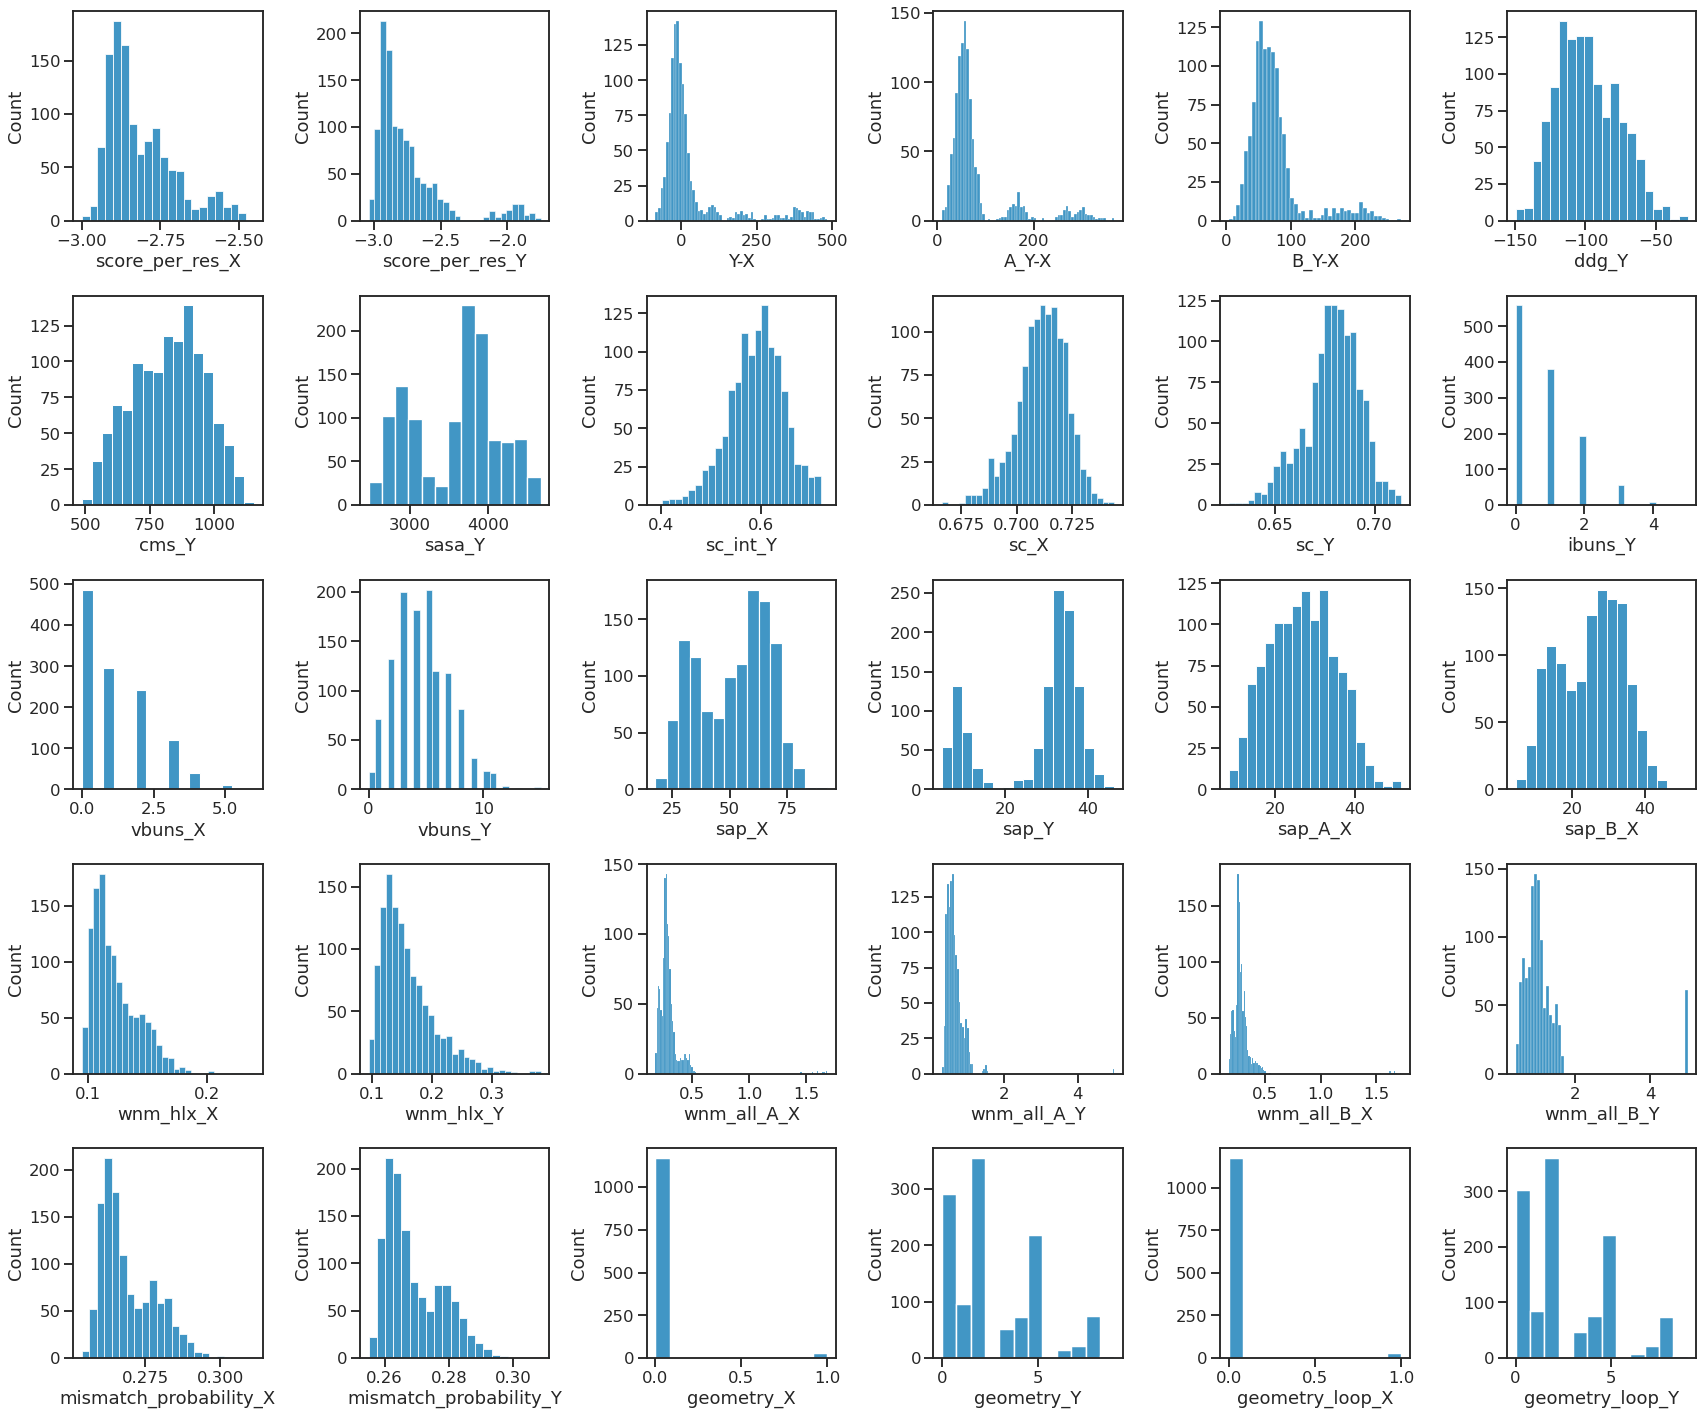

In [24]:
histplot_df(scores_df)

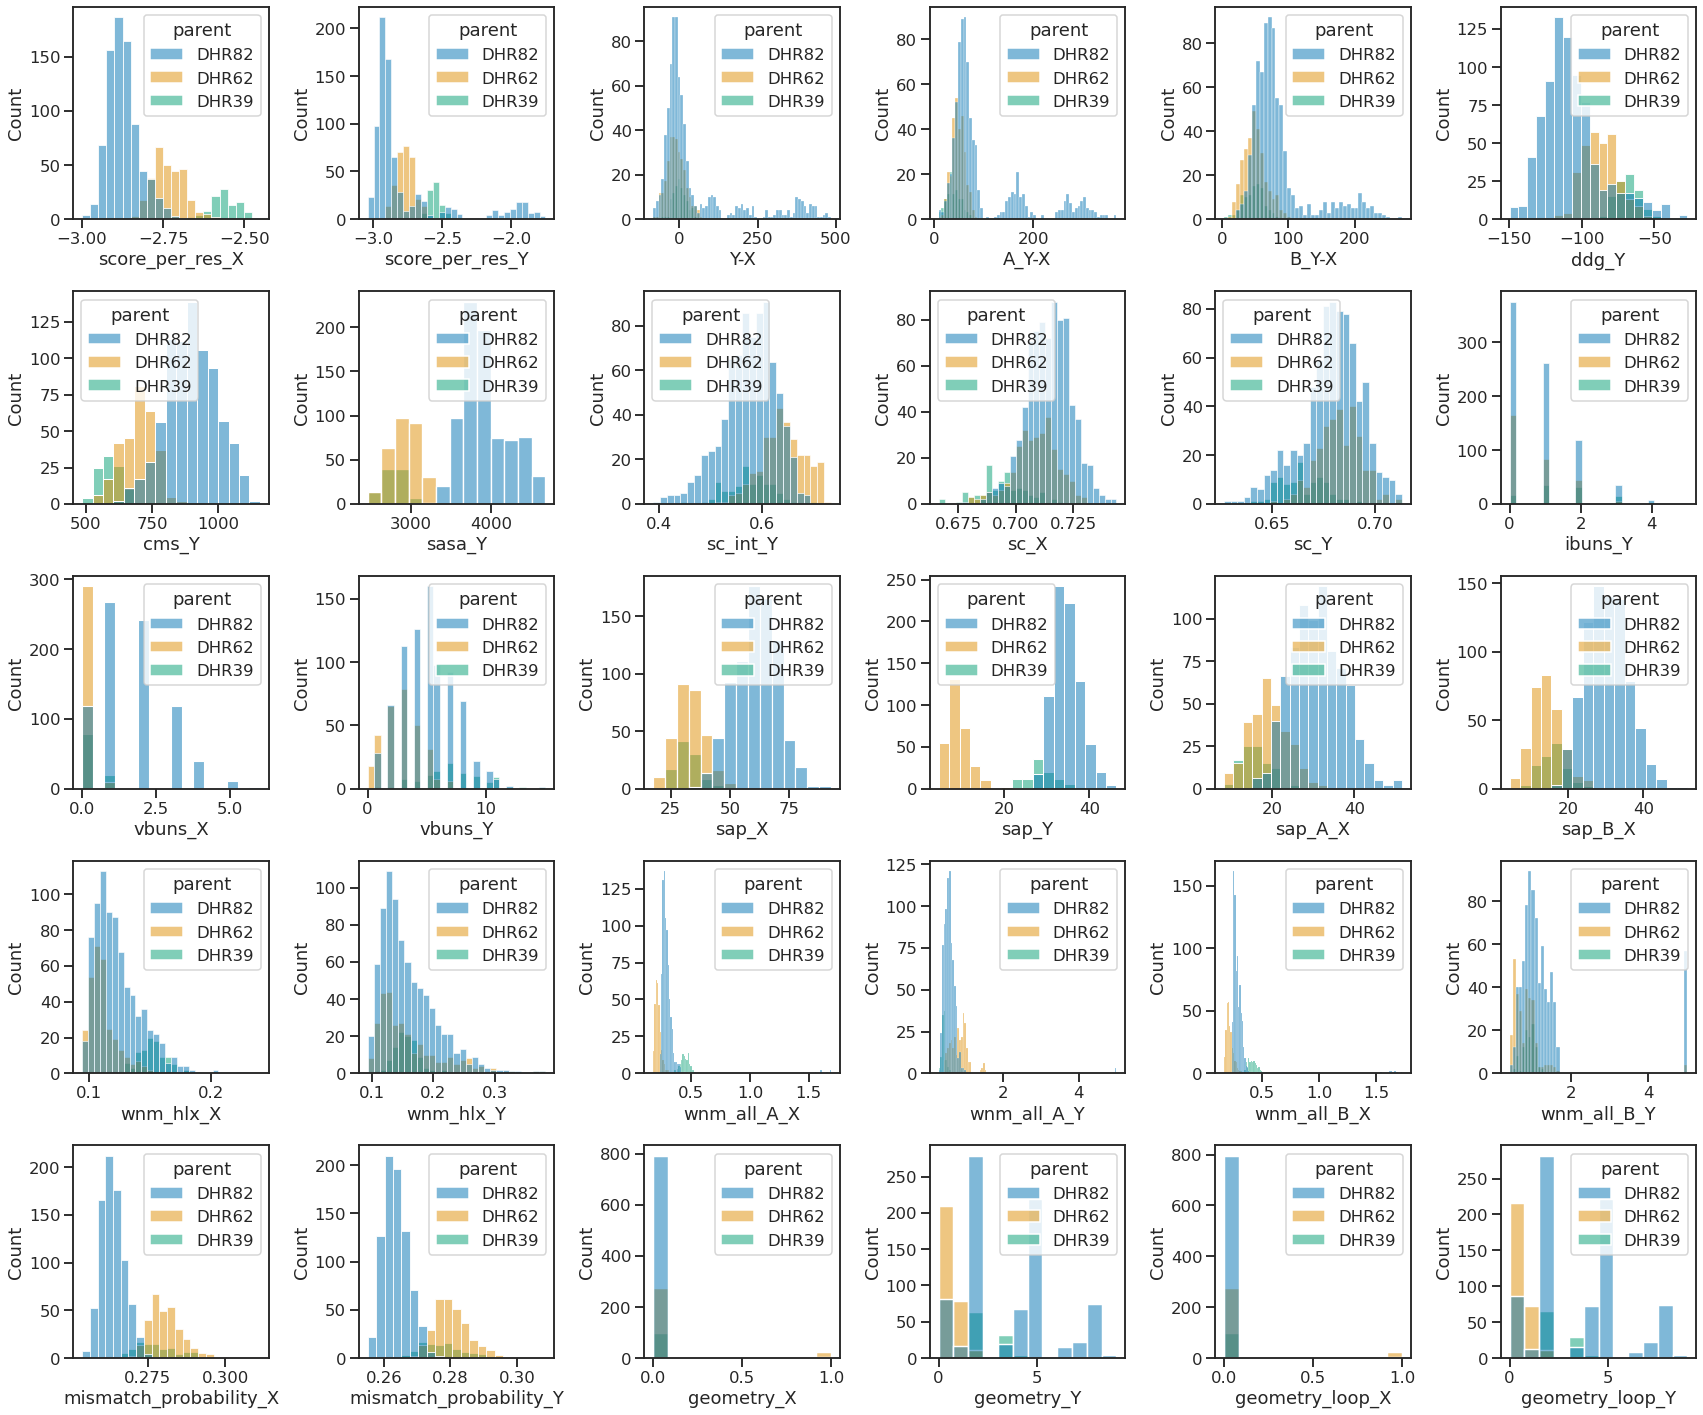

In [25]:
histplot_df(scores_df, 'parent', ['DHR82', 'DHR62', 'DHR39'])

In [26]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

8


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_2/design_decoys/ce4f5ec915372ec906042b72da9f4a385bd949db0a05b1ff.pdb,-2.708038,-2.747126,-13.446472,50.829102,58.686615,-89.237282,859.087524,3306.192871,0.714830,0.707227,0.692796,0,0,2,26.672609,5.979792,13.537651,13.134973,0.113947,0.111185,0.229315,0.806612,0.220141,0.577397,0.275885,0.277182,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/d80635950a781d87c59f2836bcceeca9f3b4ee99e13e57c8.pdb,-2.757843,-2.887338,-44.546204,39.642792,29.519989,-101.869232,702.197266,2833.653076,0.713921,0.708162,0.687441,0,0,2,32.355198,7.601293,20.641012,11.714165,0.102360,0.099030,0.221286,0.426576,0.195908,0.820768,0.273417,0.272902,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/6738c59f5f462d60301c872bf2ae1c79048d10c08bc1a4d6.pdb,-2.741040,-2.773270,-11.086853,41.245361,56.009308,-94.635277,740.352661,2916.280273,0.664764,0.701796,0.681447,0,0,2,26.332268,11.970739,12.917574,13.414684,0.124805,0.139297,0.198965,0.859922,0.219912,0.973530,0.271055,0.276863,0,1,0,0,DHR62
05_two_state/run_2/design_decoys/f39f4ff9f8d30b56bb4d10d436243fa99f0b32460ba7fc6f.pdb,-2.748993,-2.850100,-34.780823,44.241058,45.086761,-97.146019,738.176636,2977.343262,0.674361,0.709669,0.681753,1,0,0,36.746105,6.056765,24.808079,11.938018,0.098521,0.196250,0.308706,0.621212,0.214490,0.590539,0.278068,0.277417,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/cc667bb725e3602915fedea4c65ead239136e5da3f3742e7.pdb,-2.760498,-2.810434,-17.177917,66.115692,34.277802,-96.645264,740.642151,2999.862061,0.684774,0.710318,0.685481,0,0,1,28.294861,6.366314,18.969151,9.325707,0.102684,0.130509,0.228450,0.827035,0.236029,0.598420,0.273164,0.277085,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/6e8cca90a1db5e36de2c39aea869059be538c0d12387fb6d.pdb,-2.685754,-2.766308,-27.710693,65.803345,38.830139,-104.171059,778.916443,3117.574707,0.719303,0.710482,0.692741,1,0,1,34.923527,6.019622,20.003731,14.919796,0.101778,0.164294,0.229552,0.829034,0.247009,0.992425,0.294522,0.294316,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/02030d646287bc548b6b44f089471de342bdc916eacbffb0.pdb,-2.757215,-2.871432,-39.290649,40.525269,48.410431,-105.255821,748.640686,3004.400879,0.682497,0.701514,0.695069,0,0,1,32.211258,7.537124,21.040718,11.170546,0.111505,0.150837,0.193572,0.558043,0.206390,0.811039,0.278695,0.274649,0,0,0,0,DHR62
05_two_state/run_2/design_decoys/0c4da3c8aef7ff410e86c9b8ed0b6e20faa3f3fed235e1b2.pdb,-2.753616,-2.807654,-18.589294,34.260406,68.913055,-97.446953,699.081909,2804.370605,0.688909,0.713655,0.696959,0,0,1,33.588299,6.233559,13.506031,20.082258,0.101716,0.175230,0.186499,0.610166,0.193452,0.537081,0.277424,0.277854,0,0,0,0,DHR62


In [27]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.6, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 5, 0),
]

global_df_2 = filter_df(scores_df, cutoffs)
print(global_df_2['parent'].nunique())
print_scores(global_df_2[global_df_2['parent']=='DHR82'])

# increasing the vbuns_Y cutoff to 5 will get you some DHR82 designs... hmm...
# seems there is a tradeoff between vbuns_Y and sc_int_Y

64
2


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_2/design_decoys/eb370e8815fa5ce2d1e008fe002449fccbb5f74329fe3080.pdb,-2.832390,-2.893679,-28.437988,43.138000,71.401367,-121.759804,934.072021,3943.511230,0.622650,0.722345,0.699602,0,2,3,60.357449,34.465759,28.044130,32.313313,0.126361,0.185509,0.352813,0.664589,0.291992,0.859802,0.264566,0.263199,0,2,0,2,DHR82
05_two_state/run_2/design_decoys/8f254f2d5fa8d0e150d82710da8543c3ab4424302623653b.pdb,-2.855004,-2.914216,-27.474487,53.387939,63.849426,-122.522041,926.334534,3963.839355,0.612354,0.705016,0.697309,1,2,3,57.528381,32.396450,29.584267,27.944103,0.112522,0.193952,0.261853,0.514595,0.349122,0.938923,0.259055,0.259899,0,2,0,2,DHR82
05_two_state/run_2/design_decoys/207c68530aa42bd9b0825829c12905870b806e6000a5cf97.pdb,-2.880381,-2.925240,-20.814453,71.540405,60.425720,-120.930382,987.112061,4249.598145,0.610880,0.708518,0.685691,1,1,4,59.723911,38.479450,25.598022,34.125931,0.122617,0.108325,0.271794,0.536246,0.246669,0.906592,0.270265,0.270104,0,5,0,5,DHR82
05_two_state/run_2/design_decoys/f5ddf60cb5f9ed5b2dfa7a06d79443fbe14f6eb5bea4b80f.pdb,-2.869977,-2.945916,-35.235596,47.054382,81.063110,-133.274445,1038.401855,4342.857910,0.631913,0.696663,0.674595,2,0,2,65.585831,31.478350,32.901585,32.684238,0.128299,0.196612,0.306776,0.525795,0.268898,0.826325,0.259209,0.260637,0,5,0,5,DHR82
05_two_state/run_2/design_decoys/cd1b9233aa621b5e39b0e8845f38d4766247e0d8eca981d4.pdb,-2.881907,-2.919796,-17.580200,83.625366,70.643188,-136.710388,1115.436035,4410.560547,0.665351,0.718192,0.702376,0,1,3,51.806416,36.119423,25.889187,25.917261,0.118829,0.151800,0.256297,0.598630,0.309630,0.954387,0.272629,0.273752,0,5,0,5,DHR82


In [61]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/selected/des_DHR62/'
copy_designs(global_df, out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_2/selected/des_DHR82/'
copy_designs(global_df_2[global_df_2['parent']=='DHR82'], out_dir)

In [28]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_2/des_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

368
